# Classification Models for Healthcare Frauds

In [8]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
from collections import Counter
from numpy import where
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import random
import itertools
from interpret.glassbox import ExplainableBoostingClassifier 
import xgboost as xgb
from interpret.perf import ROC  
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn.pipeline import Pipeline
import os              # for directory and file manipulation
import numpy as np     # for basic array manipulation
import pandas as pd    # for dataframe manipulation
import datetime        # for timestamp
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score, roc_curve

# S3 bucket
#import sagemaker, boto3, os
#bucket = sagemaker.Session().default_bucket()
#prefix = "sagemaker-xgboost-fraud-prediction"
#! aws s3 ls {bucket}/{prefix}/data --recursive

# global constants 
ROUND = 3              # generally, insane precision is not needed 

# set global random seed for better reproducibility
SEED = 1234
seed = 1234
np.random.seed(SEED)
NTHREAD = 4

import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [48]:
tic = time.time()
path = r'/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/PartB' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding="ISO-8859-1")
    li.append(df)

partB = pd.concat(li, axis=0, ignore_index=True)
toc = time.time()
print(toc - tic)

419.83597922325134


In [50]:
%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset
# Load LEIE dataset
leie = pd.read_csv("LEIE.csv")
leie_plus = pd.read_excel("leie_nppes_matches.xlsx")

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset


In [51]:
# Load Reinstatement LEIE dataset(2020 - 2021)
path = r'/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/REIN' # use your path
all_REIN = glob.glob(path + "/*.csv")

li = []

for filename in all_REIN:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

rein_df = pd.concat(li, axis=0, ignore_index=True)

# 1. Data Cleaning & Exploration

In [7]:
partB.head(3)

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,HCPCS_Desc,HCPCS_Drug_Ind,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt
0,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,"Initial hospital inpatient care, typically 50 ...",N,F,341,357.0,357,416.546218,137.749188,107.517871,106.715294
1,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,"Initial hospital inpatient care, typically 70 ...",N,F,98,98.0,98,611.000000,201.096837,152.551224,153.220204
2,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,"Subsequent hospital inpatient care, typically ...",N,F,65,104.0,104,119.000000,39.086731,30.835385,30.677115


In [8]:
list(partB.columns)

['Rndrng_NPI',
 'Rndrng_Prvdr_Last_Org_Name',
 'Rndrng_Prvdr_First_Name',
 'Rndrng_Prvdr_MI',
 'Rndrng_Prvdr_Crdntls',
 'Rndrng_Prvdr_Gndr',
 'Rndrng_Prvdr_Ent_Cd',
 'Rndrng_Prvdr_St1',
 'Rndrng_Prvdr_St2',
 'Rndrng_Prvdr_City',
 'Rndrng_Prvdr_State_Abrvtn',
 'Rndrng_Prvdr_State_FIPS',
 'Rndrng_Prvdr_Zip5',
 'Rndrng_Prvdr_RUCA',
 'Rndrng_Prvdr_RUCA_Desc',
 'Rndrng_Prvdr_Cntry',
 'Rndrng_Prvdr_Type',
 'Rndrng_Prvdr_Mdcr_Prtcptg_Ind',
 'HCPCS_Cd',
 'HCPCS_Desc',
 'HCPCS_Drug_Ind',
 'Place_Of_Srvc',
 'Tot_Benes',
 'Tot_Srvcs',
 'Tot_Bene_Day_Srvcs',
 'Avg_Sbmtd_Chrg',
 'Avg_Mdcr_Alowd_Amt',
 'Avg_Mdcr_Pymt_Amt',
 'Avg_Mdcr_Stdzd_Amt']

In [6]:
# Include only the attributes used for data cleaning process
partB = partB[["Rndrng_NPI", 'Rndrng_Prvdr_Gndr', "Rndrng_Prvdr_Type", "HCPCS_Cd", 
               "Place_Of_Srvc", "Tot_Benes", "Tot_Srvcs", "Tot_Bene_Day_Srvcs", 
               "Avg_Sbmtd_Chrg", 'Avg_Mdcr_Alowd_Amt', "Avg_Mdcr_Pymt_Amt", 'Avg_Mdcr_Stdzd_Amt']]
partB.columns

Index(['Rndrng_NPI', 'Rndrng_Prvdr_Gndr', 'Rndrng_Prvdr_Type', 'HCPCS_Cd',
       'Place_Of_Srvc', 'Tot_Benes', 'Tot_Srvcs', 'Tot_Bene_Day_Srvcs',
       'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt', 'Avg_Mdcr_Pymt_Amt',
       'Avg_Mdcr_Stdzd_Amt'],
      dtype='object')

In [10]:
# Brief information on the partB dataset
partB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67764122 entries, 0 to 67764121
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Rndrng_NPI          int64  
 1   Rndrng_Prvdr_Gndr   object 
 2   Rndrng_Prvdr_Type   object 
 3   HCPCS_Cd            object 
 4   Place_Of_Srvc       object 
 5   Tot_Benes           int64  
 6   Tot_Srvcs           float64
 7   Tot_Bene_Day_Srvcs  int64  
 8   Avg_Sbmtd_Chrg      float64
 9   Avg_Mdcr_Alowd_Amt  float64
 10  Avg_Mdcr_Pymt_Amt   float64
 11  Avg_Mdcr_Stdzd_Amt  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 6.1+ GB


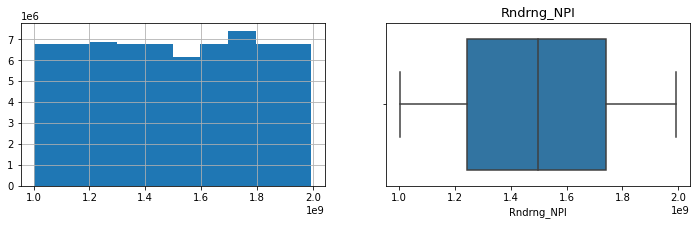

In [11]:
# Check the invalid NPI
# outliers can be invlid NPI 
plt.figure(figsize=(12,3))

plt.subplot(121)
partB["Rndrng_NPI"].hist();

plt.subplot(122)
sns.boxplot('Rndrng_NPI', data=partB)
plt.title('Rndrng_NPI', fontsize=13);

* No invlid NPIs are detected

### Missing Value Detection

In [12]:
# Detecting missing values
partB.isnull().sum(axis=0)

Rndrng_NPI                  0
Rndrng_Prvdr_Gndr     2943213
Rndrng_Prvdr_Type           0
HCPCS_Cd                    0
Place_Of_Srvc               0
Tot_Benes                   0
Tot_Srvcs                   0
Tot_Bene_Day_Srvcs          0
Avg_Sbmtd_Chrg              0
Avg_Mdcr_Alowd_Amt          0
Avg_Mdcr_Pymt_Amt           0
Avg_Mdcr_Stdzd_Amt          0
dtype: int64

* Only gender column has null values

In [13]:
# List up the unique NPIs whose gender data values are Null
NPI_missGndr = list(partB.loc[partB["Rndrng_Prvdr_Gndr"].isnull()]["Rndrng_NPI"].unique())

# Find the gender data from the other rows that have the equal NPI matching to the elements of the list above
nullGndr_df = partB.loc[partB["Rndrng_NPI"].isin(NPI_missGndr)]
partB["Rndrng_Prvdr_Gndr"].isnull().sum() == nullGndr_df["Rndrng_Prvdr_Gndr"].isnull().sum()

True

* Every row matching to the NPIs with Null gender values has missing gender values
* Remove the corresponding instances from the whole dataset

In [7]:
# Drop the "Rndrng_Prvdr_Gndr" variable to preserve every instance
partB = partB.drop("Rndrng_Prvdr_Gndr", axis = 1)

### Remove Non-Procedure HCPCS

In [8]:
%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset
# Load the Oct 2019 Drug Average Sales Price excel file
asp = pd.read_excel("asp_2019Oct.xls", usecols=[0], skiprows=[0,1,2,3,4,5,6,7,8])
asp.head(3)

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset


,HCPCS Code
0,90371
1,90375
2,90376


In [9]:
# Drop the rows that have the HCPCS codes recorded in the ASP excel file
drop_idx = partB[partB["HCPCS_Cd"].isin(asp.iloc[:,0])].index
partB = partB.drop(drop_idx)

In [10]:
# Rename the columns 
partB.rename(columns = {"Rndrng_NPI":"NPI", "Rndrng_Prvdr_Type":"Type"}, inplace = True)

### Labeling

In [53]:
# Rename NPI, DATE, TYPE columns of the LEIE Plus dataset to combine with the other two LEIE datasets 
leie_plus.rename(columns = {"NPPES_NPI":"NPI", "EXCLUDED_DATE":"EXCLDATE", "EXCLUDED_TYPE":"EXCLTYPE"}, inplace = True)

In [54]:
# Combine the three LEIE datasets
leie_comb = pd.concat([leie[["NPI", "EXCLTYPE", "EXCLDATE"]], 
                       rein_df[["NPI", "EXCLTYPE", "EXCLDATE"]],
                       leie_plus[["NPI", "EXCLTYPE", "EXCLDATE"]]], 
                      ignore_index = True)

In [13]:
# Convert the integer type of EXCLDATE to date format
leie_comb['EXCLDATE'] = pd.to_datetime(leie_comb['EXCLDATE'], format = '%Y%m%d')

# Convert the upper-case letters to lower case
leie_comb['EXCLTYPE'] = leie_comb[['EXCLTYPE']].applymap(str.lower)

In [14]:
# Check the Exclusion types (OIG Acts)
leie_comb["EXCLTYPE"].value_counts()

1128b4       31417
1128a1       22627
1128a2        7215
1128a3        4648
1128a4        3029
1128b14       2333
1128b8        1600
1128b1         860
1128b5         831
1128b7         692
1128b3         313
1128aa         152
1128b6          67
1128b2          59
1156            57
1128b15         36
brch sa         18
brch cia        14
1128b11         11
1128a1          11
1160             9
1128b16          3
1128a3           2
1128b12          1
Name: EXCLTYPE, dtype: int64

In [15]:
# Make a list with the OIG rules that correspond to fradulent behaviors
label_list = ["1128a1", "1128a2", "1128a3", "1128a4", 
              "1128b1", "1128b6", "1128b7", "1128b2", 
              "1128b4", "1128b5", "1128b8", "1128b15", 
              "1128b16"]

# Filter the column "NPI" and the rows matching to valid NPI, fraud-related exclusion types, and exclusion date before 2020
end_date = "2019-12-31"
leie_new = leie_comb["NPI"][(leie_comb["EXCLTYPE"].isin(label_list)) 
                       & (leie_comb["NPI"] != 0 ) 
                       & (leie_comb["EXCLDATE"] <= end_date)]


In [16]:
# Label each row with fraud = 1/ non-fraud = 0
fraud_npi_list = leie_new.tolist()
partB['Fraud'] = np.where(partB['NPI'].isin(fraud_npi_list), 1, 0)

In [17]:
print("Total number of LEIE data: %d" % len(leie_comb))
print("Number of invalid NPI: %d" % len(leie_comb['NPI'][leie_comb["NPI"] == 0]))
print("Total number of valid NPI: %d" % (len(leie_comb) - len(leie_comb['NPI'][leie_comb["NPI"] == 0])))
print("Number of valid NPI matching to frauds: %d" % len(leie_new))
print("Number of Fraud label: %d" % len(partB[partB["Fraud"] == 1]))

Total number of LEIE data: 76005
Number of invalid NPI: 69465
Total number of valid NPI: 6540
Number of valid NPI matching to frauds: 5489
Number of Fraud label: 33638


In [18]:
# Ratio of the two classes
partB["Fraud"].value_counts()

0    65655982
1       33638
Name: Fraud, dtype: int64

### Under-sampling the majority group to reduce the size of the dataset

In [24]:
partB_copy = partB.copy()

In [25]:
# Assign X and y features
feature = list(partB_copy.columns)

feature.remove("Fraud")

target = "Fraud"

In [26]:
undersample = under_sampling.RandomUnderSampler(sampling_strategy=0.05)
X, y = undersample.fit_resample(partB_copy[feature], partB_copy[[target]])

In [28]:
under_partB = pd.concat([X, y], axis = 1)
under_partB.head()

,NPI,Type,HCPCS_Cd,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Fraud
0,1831344373,Internal Medicine,90732,O,17,17.0,17,165.00,111.557059,111.557059,111.557647,0
1,1245569938,Internal Medicine,99232,F,133,294.0,294,126.00,71.730000,57.150000,56.730000,0
2,1801962881,Internal Medicine,G0121,O,77,77.0,77,735.00,441.186494,441.186494,384.715584,0
3,1811063118,Internal Medicine,Q2037,O,58,58.0,58,25.00,15.090000,15.090000,15.090000,0
4,1235130766,Pathology,84166,O,21,24.0,24,50.25,18.694583,12.209167,13.367917,0


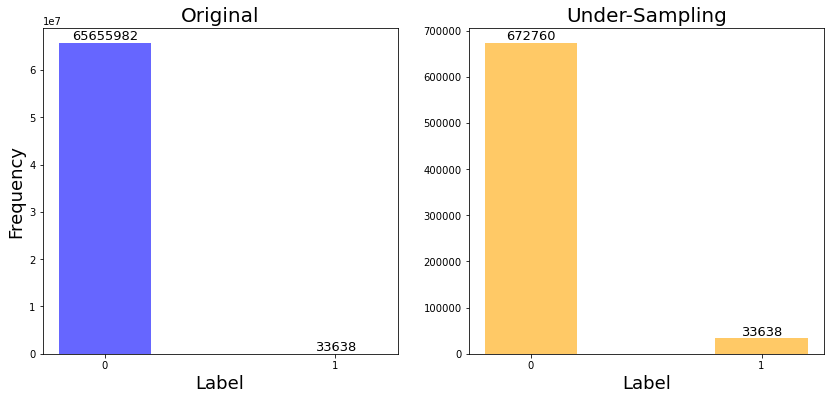

In [29]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(partB_copy[target].value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_under = list(under_partB[target].value_counts())

plot_under = plt.bar(Labels, Y_fraud_under, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_under:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Under-Sampling", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

In [30]:
# Drop the HCPCS_Cd feature
under_partB = under_partB.drop("HCPCS_Cd", axis = 1)
under_partB.head()

,NPI,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Fraud
0,1831344373,Internal Medicine,O,17,17.0,17,165.00,111.557059,111.557059,111.557647,0
1,1245569938,Internal Medicine,F,133,294.0,294,126.00,71.730000,57.150000,56.730000,0
2,1801962881,Internal Medicine,O,77,77.0,77,735.00,441.186494,441.186494,384.715584,0
3,1811063118,Internal Medicine,O,58,58.0,58,25.00,15.090000,15.090000,15.090000,0
4,1235130766,Pathology,O,21,24.0,24,50.25,18.694583,12.209167,13.367917,0


In [ ]:
# Export the cleaned dataset to a csv file

under_partB.to_csv("/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB/processed_partB.csv", index=False, header = True)

### -------------------------------

In [9]:
# import the cleaned dataset 

%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB
partB = pd.read_csv("processed_partB.csv")

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset


### --------------------------------

In [40]:
partB.head()

,NPI,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Fraud
0,1679548440,Dermatology,O,25,46.0,46,281.000000,128.275435,100.793043,102.845000,0
1,1184730848,Podiatry,O,15,19.0,19,18.962105,18.571579,13.215263,14.241579,0
2,1700097557,Diagnostic Radiology,F,32,32.0,32,27.000000,9.387187,7.243750,7.091250,0
3,1659528339,Mass Immunizer Roster Biller,O,112,114.0,114,4.940614,4.366404,4.366404,6.134737,0
4,1982966685,Family Practice,O,112,114.0,114,35.000000,25.290000,25.290000,20.502368,0


In [41]:
partB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370018 entries, 0 to 370017
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   NPI                 370018 non-null  int64  
 1   Type                370018 non-null  object 
 2   Place_Of_Srvc       370018 non-null  object 
 3   Tot_Benes           370018 non-null  int64  
 4   Tot_Srvcs           370018 non-null  float64
 5   Tot_Bene_Day_Srvcs  370018 non-null  int64  
 6   Avg_Sbmtd_Chrg      370018 non-null  float64
 7   Avg_Mdcr_Alowd_Amt  370018 non-null  float64
 8   Avg_Mdcr_Pymt_Amt   370018 non-null  float64
 9   Avg_Mdcr_Stdzd_Amt  370018 non-null  float64
 10  Fraud               370018 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 31.1+ MB


### Ratio of Fraud and Non-fraud classes 

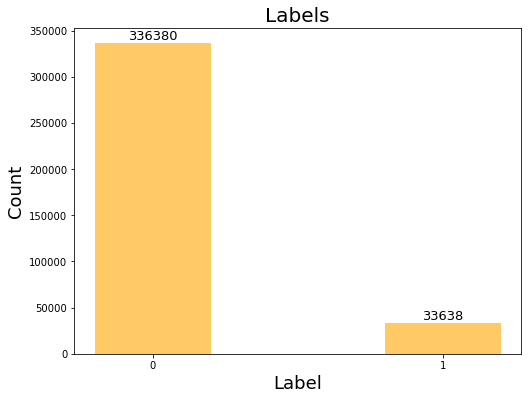

In [42]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [43]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Non-Fraud: ", round(ratio[0]*100, 2), "%")
print("Fraud: ", round(ratio[1]*100, 2), "%")

Non-Fraud:  90.91 %
Fraud:  9.09 %


### One-Hot Encoding

In [44]:
partB.Type.unique().tolist()

['Dermatology',
 'Podiatry',
 'Diagnostic Radiology',
 'Mass Immunizer Roster Biller',
 'Family Practice',
 'Physician Assistant',
 'Internal Medicine',
 'Orthopedic Surgery',
 'Cardiology',
 'Ambulatory Surgical Center',
 'Physical Therapist in Private Practice',
 'Endocrinology',
 'Pathology',
 'Emergency Medicine',
 'Gastroenterology',
 'Neurology',
 'Clinical Laboratory',
 'Urology',
 'Medical Oncology',
 'Obstetrics/Gynecology',
 'Cardiac Surgery',
 'Hematology',
 'Pulmonary Disease',
 'Nephrology',
 'Neurosurgery',
 'Obstetrics & Gynecology',
 'Chiropractic',
 'Anesthesiology',
 'Interventional Radiology',
 'Ophthalmology',
 'Otolaryngology',
 'Physical Therapist',
 'Nurse Practitioner',
 'Licensed Clinical Social Worker',
 'Cardiac Electrophysiology',
 'Sports Medicine',
 'Radiation Oncology',
 'Psychiatry',
 'Hematology-Oncology',
 'Colorectal Surgery (Proctology)',
 'Mass Immunization Roster Biller',
 'General Surgery',
 'Hematology/Oncology',
 'CRNA',
 'Nuclear Medicine',
 'C

In [5]:
# One-Hot Encoding 

# Convert the Fraud variable to object datatype
partB["Fraud"] = partB["Fraud"].astype(object)

# Encoding
encoded_partB = pd.get_dummies(partB, drop_first = True)

# Rename some of the changed variable names
encoded_partB.rename(columns = {"Fraud_1":"Fraud", "Place_Of_Srvc_O":"Place_Of_Srvc"}, inplace = True)

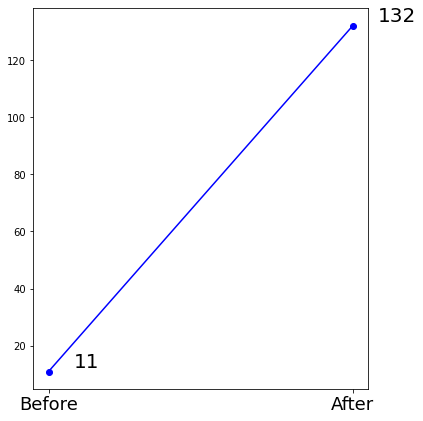

In [6]:
# Feature size of the encoded dataset 

fig, ax = plt.subplots(figsize=(6,7))

xs = ["Before", "After"]
ys = [len(partB.columns), len(encoded_partB.columns)]
ax.plot(xs, ys, "bo-")

for x,y in zip(xs, ys):
    label = "{:d}".format(y)
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(25,4), 
                 ha='left',
                fontsize = 20) 
    
ax.set_xticklabels(xs, fontsize=18)

plt.show()

### Data Spliting

In [7]:
# Assign X and y features

X_var = list(encoded_partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [8]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(encoded_partB[X_var], 
                                                    encoded_partB[y_var], 
                                                    test_size=0.2, 
                                                    stratify=encoded_partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [49]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0, test_1/test_0]})

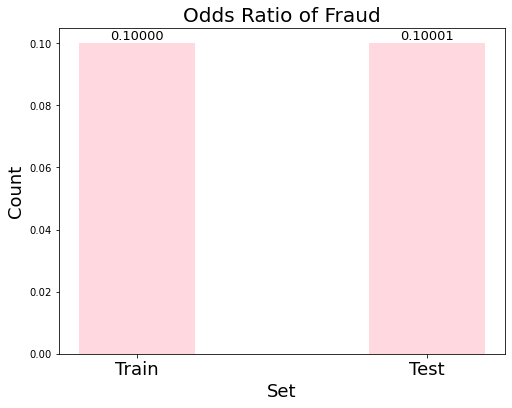

In [50]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"],
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Odds Ratio of Fraud", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

### Histogram 

In [51]:
cont_features = partB.columns.tolist()
for var in ["NPI", "Type", 'Place_Of_Srvc', "Fraud"]:
    cont_features.remove(var)

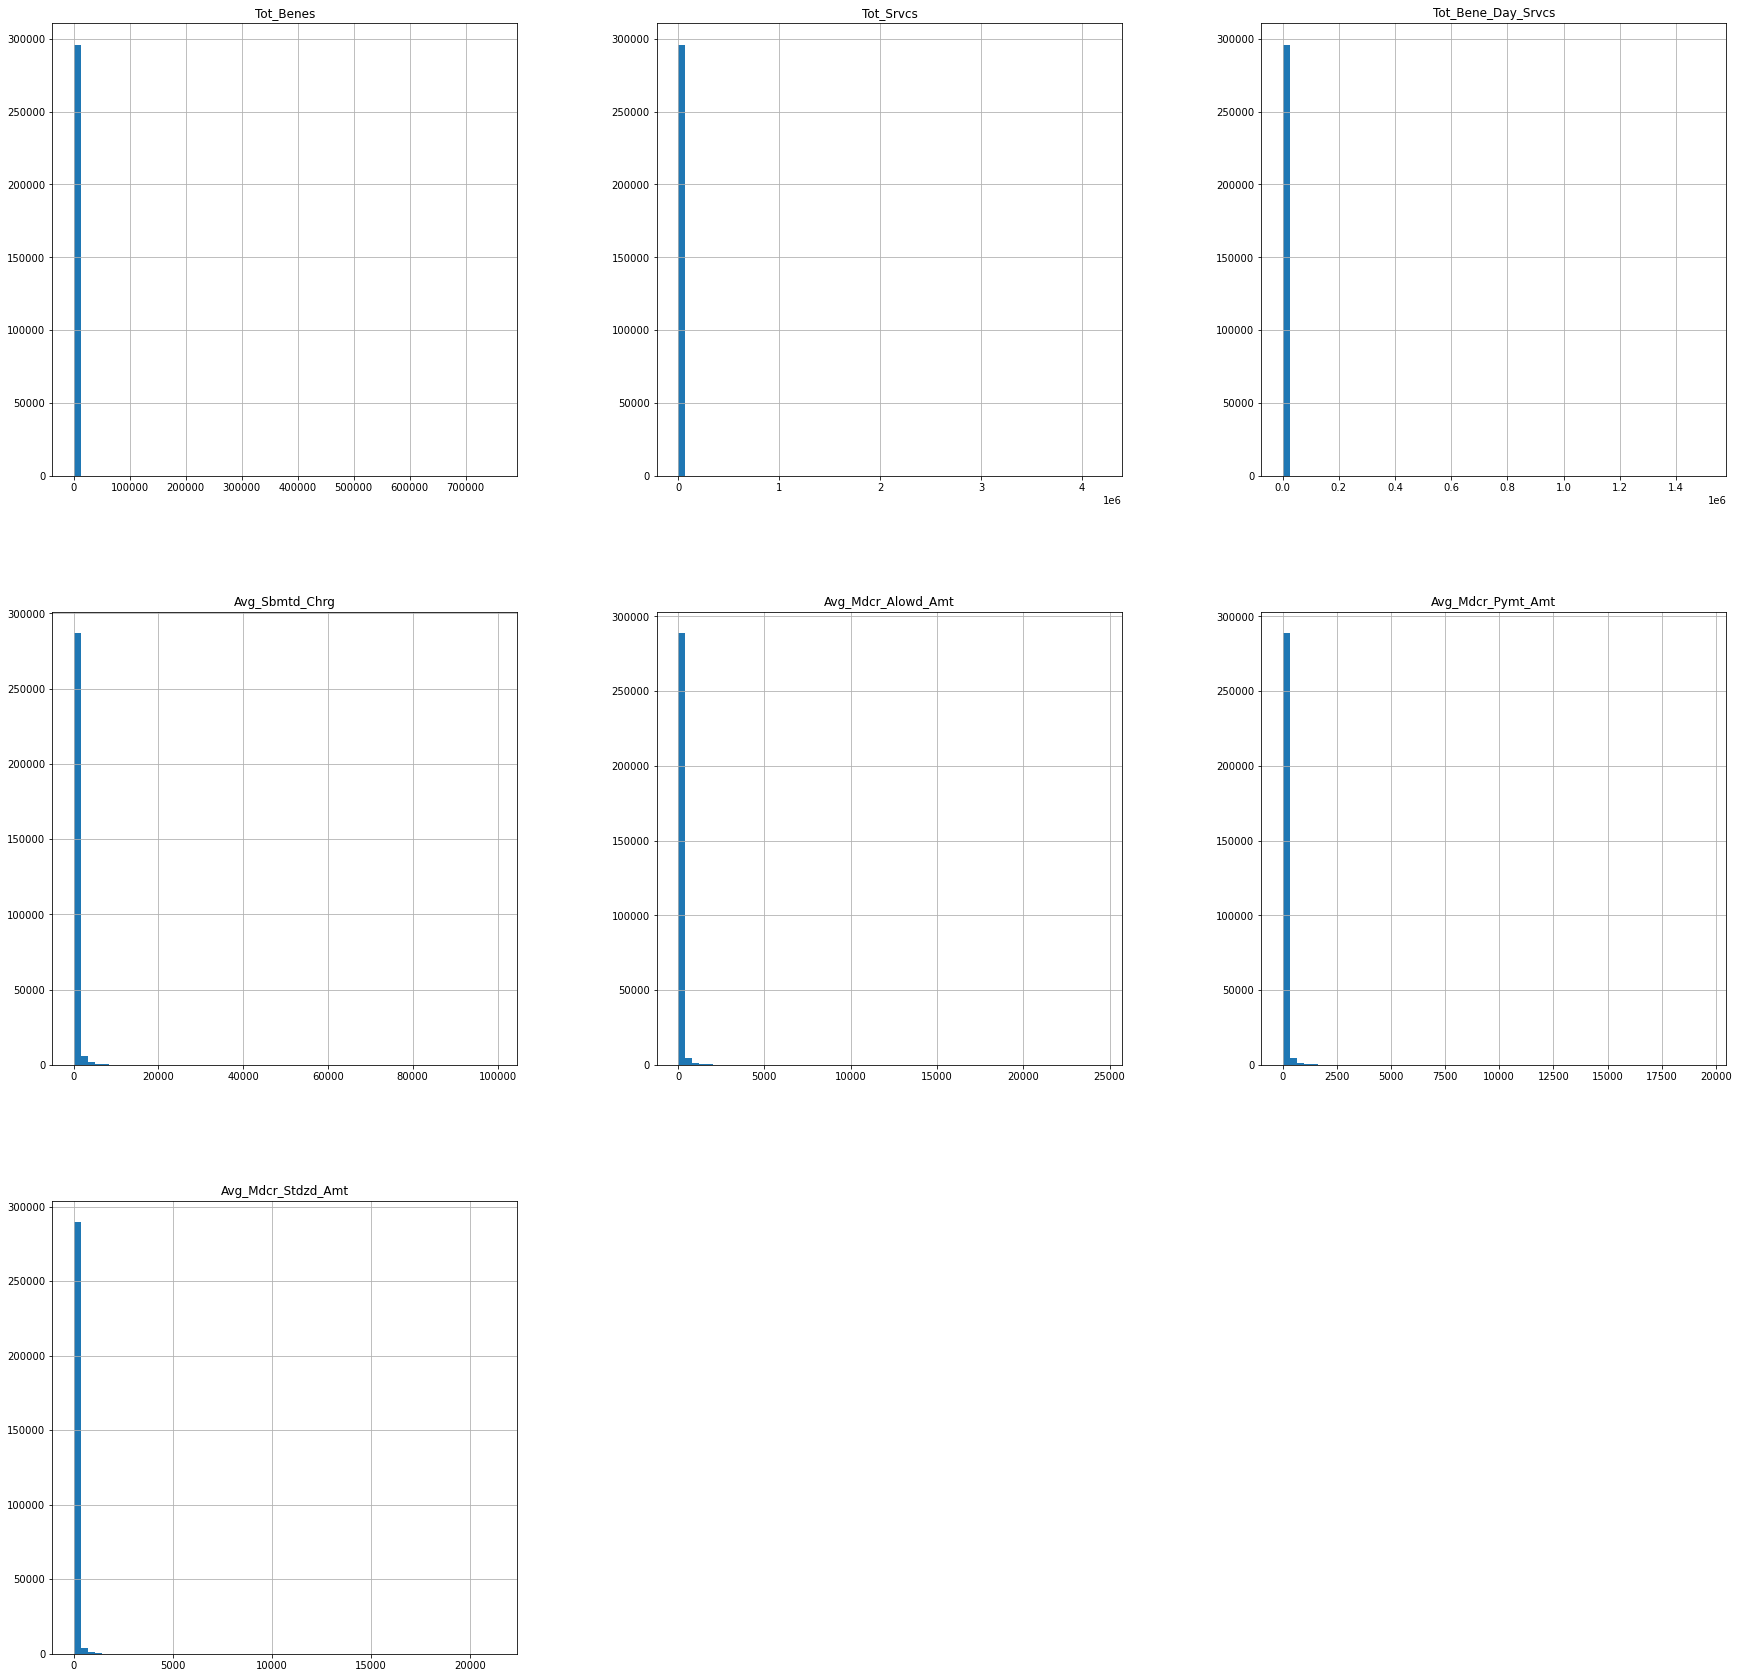

In [19]:
# Histograms

_ = tr_df[cont_features].hist(bins=60, figsize=(30, 30))

### Heat map for correlations

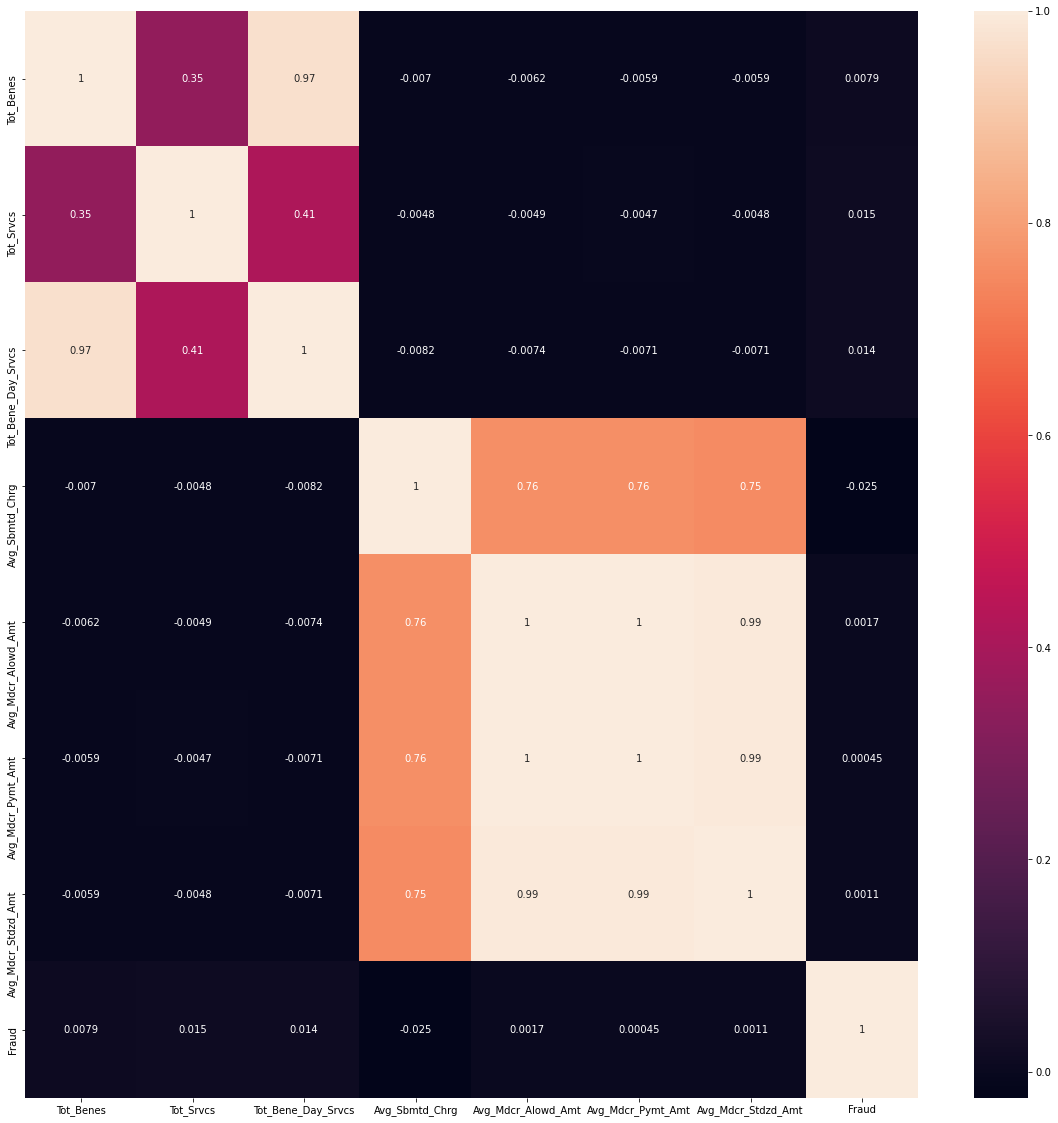

In [20]:
# Check Multicollinearity 
plt.figure(figsize = (20,20))

corr = tr_df[cont_features + [y_var]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

### creating interaction features

### box plots

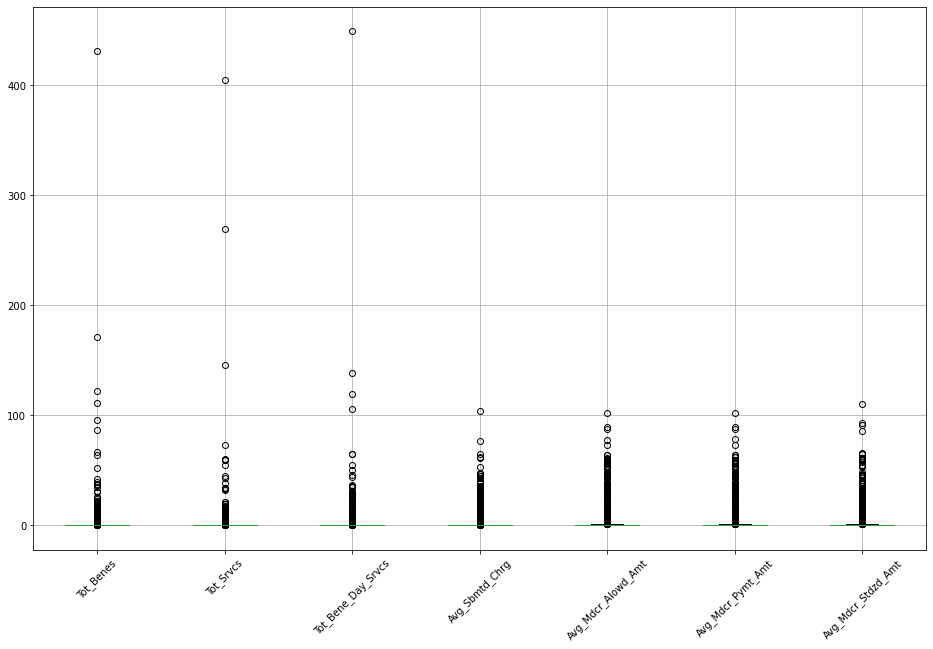

In [32]:
# in order to draw the box plots of all the features in the same y-axis, scale the variables
scaled_tr = pd.DataFrame(scale(tr_df[cont_features]), columns = cont_features)

# box plots for the continous variables 
plt.figure(figsize=(16, 10))

scaled_tr.boxplot()
plt.xticks(rotation=45)
plt.show()

### Outlier Detection

In [90]:
# Outlier = |z-score| > 3
def detect_outlier(var_list):
    
    threshold=3
    outliers_idx = {}
    outliers_data = {}
    
    
    for col in var_list:
        
        mean1 = np.mean(tr_df[col])
        std1 =np.std(tr_df[col])

        z_score = np.abs((tr_df[col] - mean1)/std1)
        outliers_idx[col] =  z_score.index[z_score > threshold].tolist()
        outliers_data[col] =  z_score[z_score > threshold].tolist()
       
    return outliers_idx, outliers_data

In [92]:
outliers_idx_dict, outliers_data_dict = detect_outlier(cont_features)

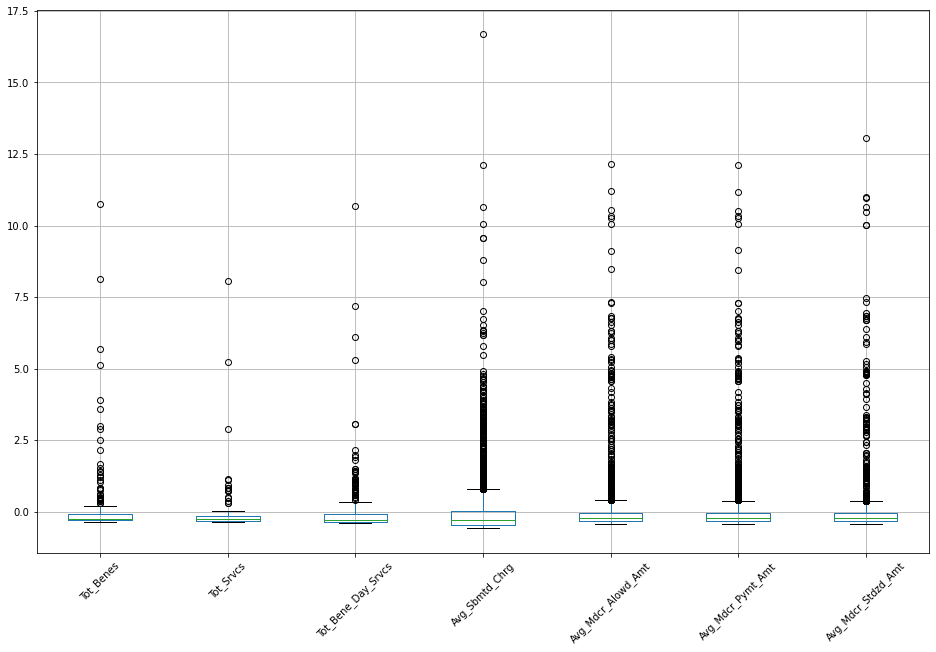

In [93]:
# Outliers of the outliers
outlier_df = pd.DataFrame({key:pd.Series(value) for key, value in outliers_data_dict.items()})

# To draw the box plots of all the features in the same y-axis, scale the variables
scaled_outlier = pd.DataFrame(scale(outlier_df[cont_features]), columns = cont_features)

# Plot
plt.figure(figsize=(16, 10))

scaled_outlier.boxplot()
plt.xticks(rotation=45)
plt.show()

In [97]:
# Find the unique indeces of the detected outliers

outliers_list = outliers_idx_dict.get("Tot_Benes")
for i in np.arange(1, len(cont_features)):
    outliers_list.extend(outliers_idx_dict.get(cont_features[i]))
    
outlier_uniq_idx = np.unique(outliers_list).tolist()


# delete the ourlier rows from the train set

orgl_len = len(tr_df)

tr_df = tr_df.drop(index = outlier_uniq_idx, axis = 0)

deleted_rows = orgl_len - len(tr_df)
print("the number of deleted rows: %d" % deleted_rows)

the number of deleted rows: 4711


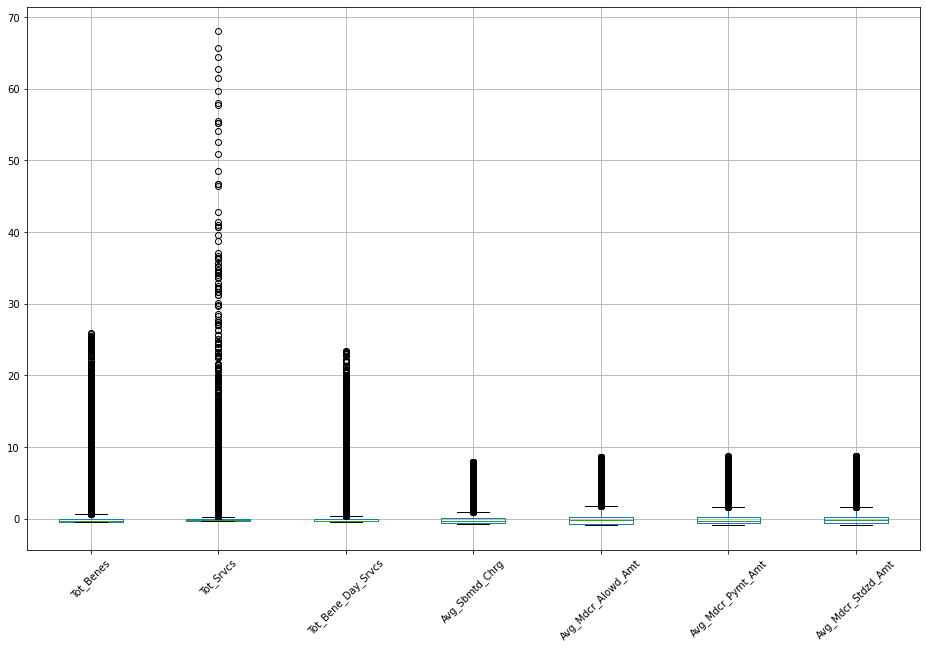

In [98]:
# Box plots for Outlier-free train set

# To draw the box plots of all the features in the same y-axis, scale the variables
scaled_tr_outlierFree = pd.DataFrame(scale(tr_df[cont_features]), columns = cont_features)

# box plots for the continous variables 
plt.figure(figsize=(16, 10))

scaled_tr_outlierFree.boxplot()
plt.xticks(rotation=45)
plt.show()

* data are extremely skewed to the right 

### -----------------SMOTE---------------------

In [52]:
tr_df.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,Fraud
259747,39,45.0,45,47.000000,14.846000,14.846000,14.846000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
130090,11,12.0,12,206.583333,71.249167,56.807500,57.317500,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44885,26,31.0,31,419.000000,225.988065,176.909355,185.982903,0,0,0,...,0,0,0,0,0,0,0,0,1,0
28449,13,13.0,13,110.000000,89.345385,89.345385,97.642308,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83030,93,370.0,370,138.335135,68.587297,54.653027,57.057027,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Scatter Plot of The Imbalanced Data

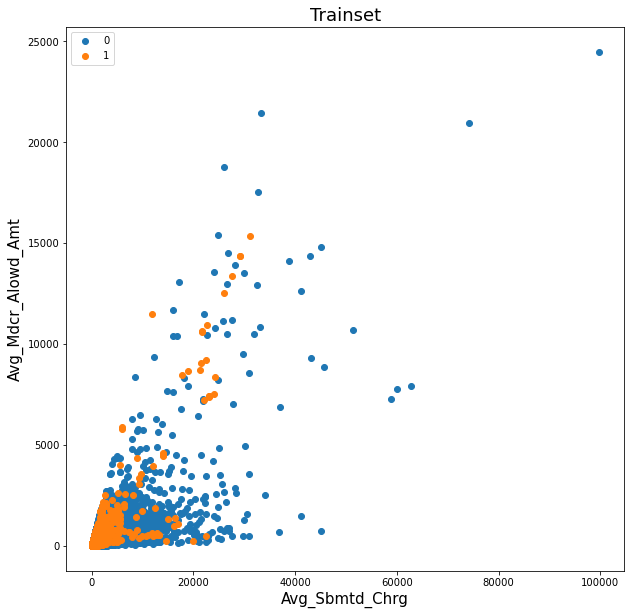

In [53]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(tr_df[y_var] == label)[0]
    plt.scatter(tr_df[X_var].iloc[row_ix, 3], tr_df[X_var].iloc[row_ix, 4], label=str(label))

plt.title("Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### Over-Sampling the imbalnaced data through SMOTE

In [9]:
# transform the dataset
oversample = over_sampling.SMOTE(random_state=SEED)
tr_X, tr_y = oversample.fit_resample(tr_df[X_var], tr_df[y_var])

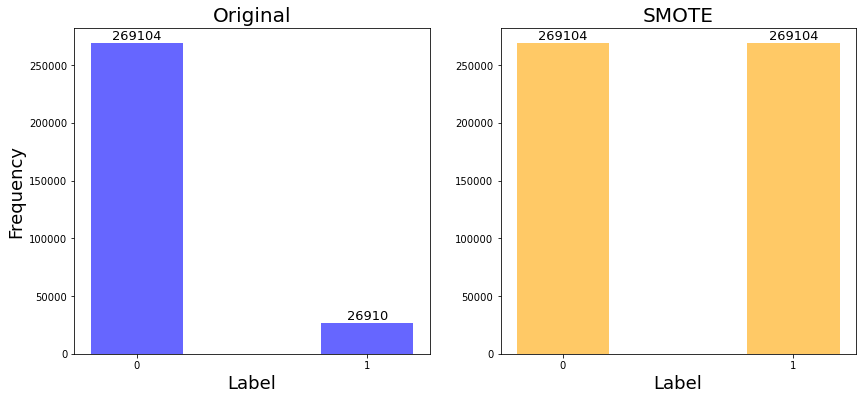

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(y_train.value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(tr_y.value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

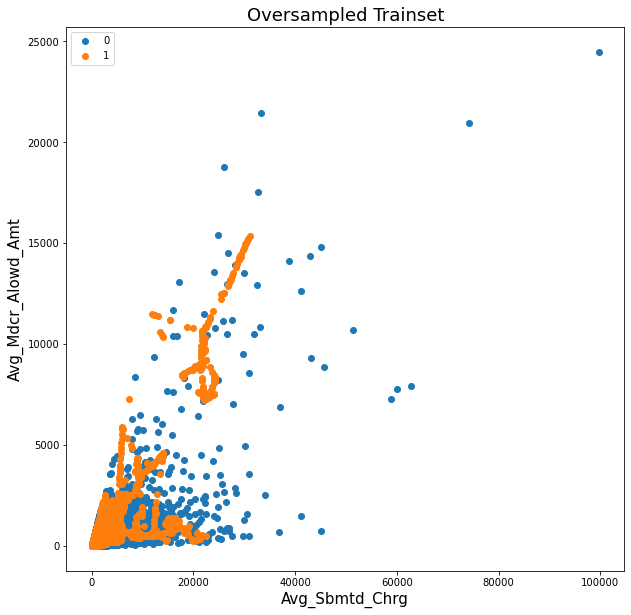

In [56]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### ------------------SMOTE & Under-Sampling-------------------------

In [122]:
# SMOTE the Fraud data increasing its size to a 10% of the number of Non-fraud data 
# and then reduce the number of Non-fraud data to have 50 percent more than the Fraud data using random under-sampling
over = over_sampling.SMOTE(sampling_strategy=0.3)
under = under_sampling.RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [123]:
# transform the dataset
#tr_X, tr_y = pipeline.fit_resample(x_train, y_train)

tr_X, tr_y = pipeline.fit_resample(tr_df[X_var], tr_df[y_var])

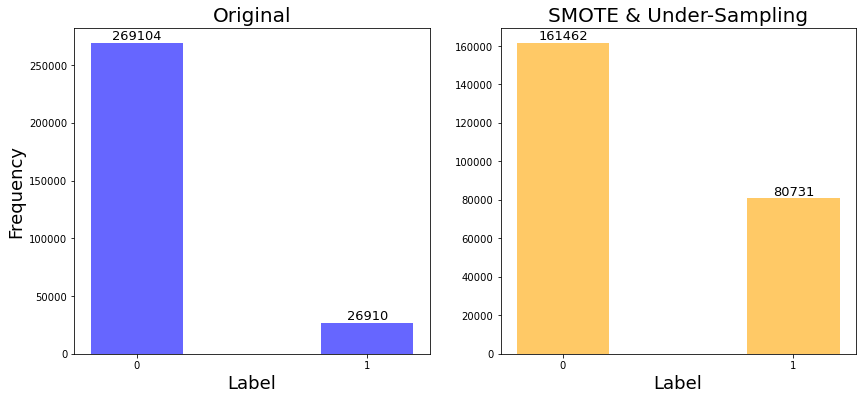

In [125]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(tr_df[y_var].value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


# After SMOTE & Random Undersampling transformation 
plt.subplot(122)

# Plot the bar graph for SMOTE & Undersampled train
Y_fraud = list(tr_y.value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("SMOTE & Under-Sampling", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
 
# Display the graph on the screen
plt.show()

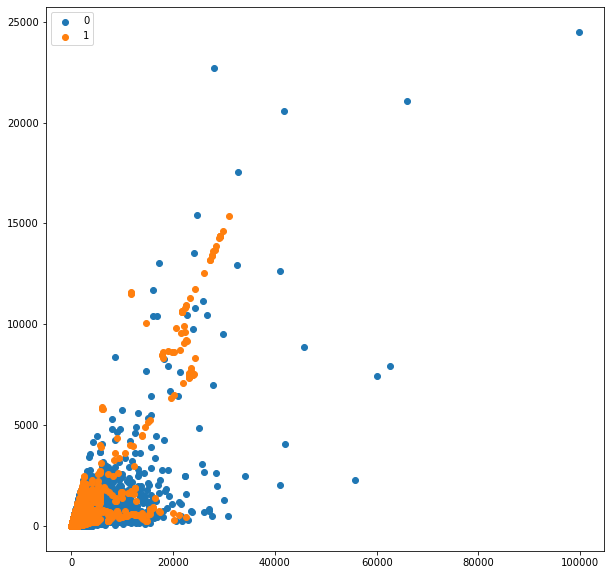

In [127]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))
plt.legend()
plt.show()

## Model Training 

### Data Partitioning (Train & Valid)

In [8]:
trans_tr_df = pd.concat([tr_X, tr_y], axis = 1)

In [9]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.7 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(trans_tr_df)) < ratio # define indices of 70% corresponding to the training set

train = trans_tr_df[split]
valid = trans_tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 377014, columns = 131
Validation data rows = 161194, columns = 131


## --------------------EBM---------------------

In [10]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

In [11]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, X_var, y_var, gs_params=gs_params, n_models=1, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/1:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 1234, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/1: 0.9519.
---------- ----------
EBM training completed in 2166.31 s.


In [12]:
# Print AUC of the best trained model 
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[X_var], valid[y_var])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.9519.


In [143]:
# Export phat computed by test X to S3 bucket
best_ebm_table = pd.DataFrame(best_ebm.predict_proba(te_df[X_var])[:, 1], columns=['Fraud'])
best_ebm_table.to_csv('best_ebm_No_Gender.csv', index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/best_ebm_No_Gender.csv')).upload_file('best_ebm_No_Gender.csv')

In [144]:
# Export test Y to S3 bucket
te_df["Fraud"].to_csv('best_ebm_No_Gender_test_Y.csv', index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/best_ebm_No_Gender_test_Y.csv')).upload_file('best_ebm_No_Gender_test_Y.csv')

## -------------XGBoost----------------

In [ ]:
#mono_constraints=None

#mono_constraints=mono_constraints

In [66]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

In [29]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7], 
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

#define monotonicity constraints
#train_corr_y = train[X_var + [y_var]].corr()[y_var].values[:-1]
#train_corr_y[np.isnan(train_corr_y)] = 1
#mono_constraints = tuple(int(i) for i in np.sign(train_corr_y))

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[X_var], train[y_var])
dvalid = xgb.DMatrix(valid[X_var], valid[y_var])

# Monotonic XGBoost grid search                        
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=20, ntree=1000, early_stopping_rounds=100, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/20: 0.9844.
---------- ----------
Grid search run 2/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.1}
---------- ----------
Grid search run 3/20:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'r

In [73]:
gs_params = {'colsample_bytree': [0.7],
             'colsample_bylevel': [0.9],
             'eta': [0.5],
             'max_depth': [7], 
             'reg_alpha': [0.005],
             'reg_lambda': [0.005],
             'subsample': [0.9],
             'min_child_weight': [1], 
             'gamma': [0.2]}

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[X_var], train[y_var])
dvalid = xgb.DMatrix(valid[X_var], valid[y_var])

best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1234, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/1: 0.9845.
---------- ----------


In [74]:
# Print AUC of the best trained model

print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.9845.


### Combine valid set with the best prediction


In [75]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
best_mxgb_phat = pd.concat([valid[X_var].reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,phat
0,48,53.0,53,265.000000,131.160000,103.620000,108.890000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.025530
1,50,93.0,93,300.000000,121.645806,97.035914,74.336667,0,0,0,...,0,0,0,0,0,0,0,0,1,0.002980
2,43,57.0,57,100.000000,97.343684,65.437719,73.009649,0,0,0,...,0,0,0,0,0,0,0,0,1,0.471521
3,77,77.0,77,18.370000,15.332597,12.218182,14.673506,0,0,0,...,0,0,0,0,0,0,0,0,1,0.586782
4,365,365.0,365,170.178082,159.057562,159.057562,159.057562,0,0,0,...,0,0,0,0,0,0,0,0,1,0.324920


## Feature Importance
### Global Feature Importance (Shapley Value)

In [78]:
# calculate shapley values and transform it to a matrix
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))
shap_contribs_matrix = np.matrix(shapley_contribs)
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 0.07177273 -0.71960324 -0.3549543  ...  0.02799543 -0.6457364
  -0.3266785 ]
 [ 0.28917265  0.6750964  -1.3094258  ...  0.0241877   0.08798464
  -0.3266785 ]
 [ 0.31696817 -0.04218274 -0.35302687 ...  0.03072747  0.14515191
  -0.3266785 ]
 ...
 [ 0.3130633   1.8858057   0.45472863 ...  0.03166348  0.11872078
  -0.3266785 ]
 [ 0.04410861  0.9425447  -0.35460752 ...  0.02757203  0.08092973
  -0.3266785 ]
 [-0.6880383   2.1964643  -0.9025264  ...  0.03114292  0.07166745
  -0.3266785 ]]

Shapley contributions rows = 161194, columns = 131


### Mean Absolute Shapley Values

In [79]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=X_var + ['intercept'])
global_fi = pd.DataFrame(np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean(), columns = ['MXGB Importance'])
print(global_fi)

                                          MXGB Importance
Tot_Benes                                        0.605630
Tot_Srvcs                                        2.024930
Tot_Bene_Day_Srvcs                               0.802517
Avg_Sbmtd_Chrg                                   0.506430
Avg_Mdcr_Alowd_Amt                               0.694292
...                                                   ...
Type_Unknown Supplier/Provider                   0.000000
Type_Unknown Supplier/Provider Specialty         0.000000
Type_Urology                                     0.179905
Type_Vascular Surgery                            0.060366
Place_Of_Srvc                                    0.223519

[130 rows x 1 columns]


### Bar chart on the Shapley Values

Text(0, 0.5, 'Features')

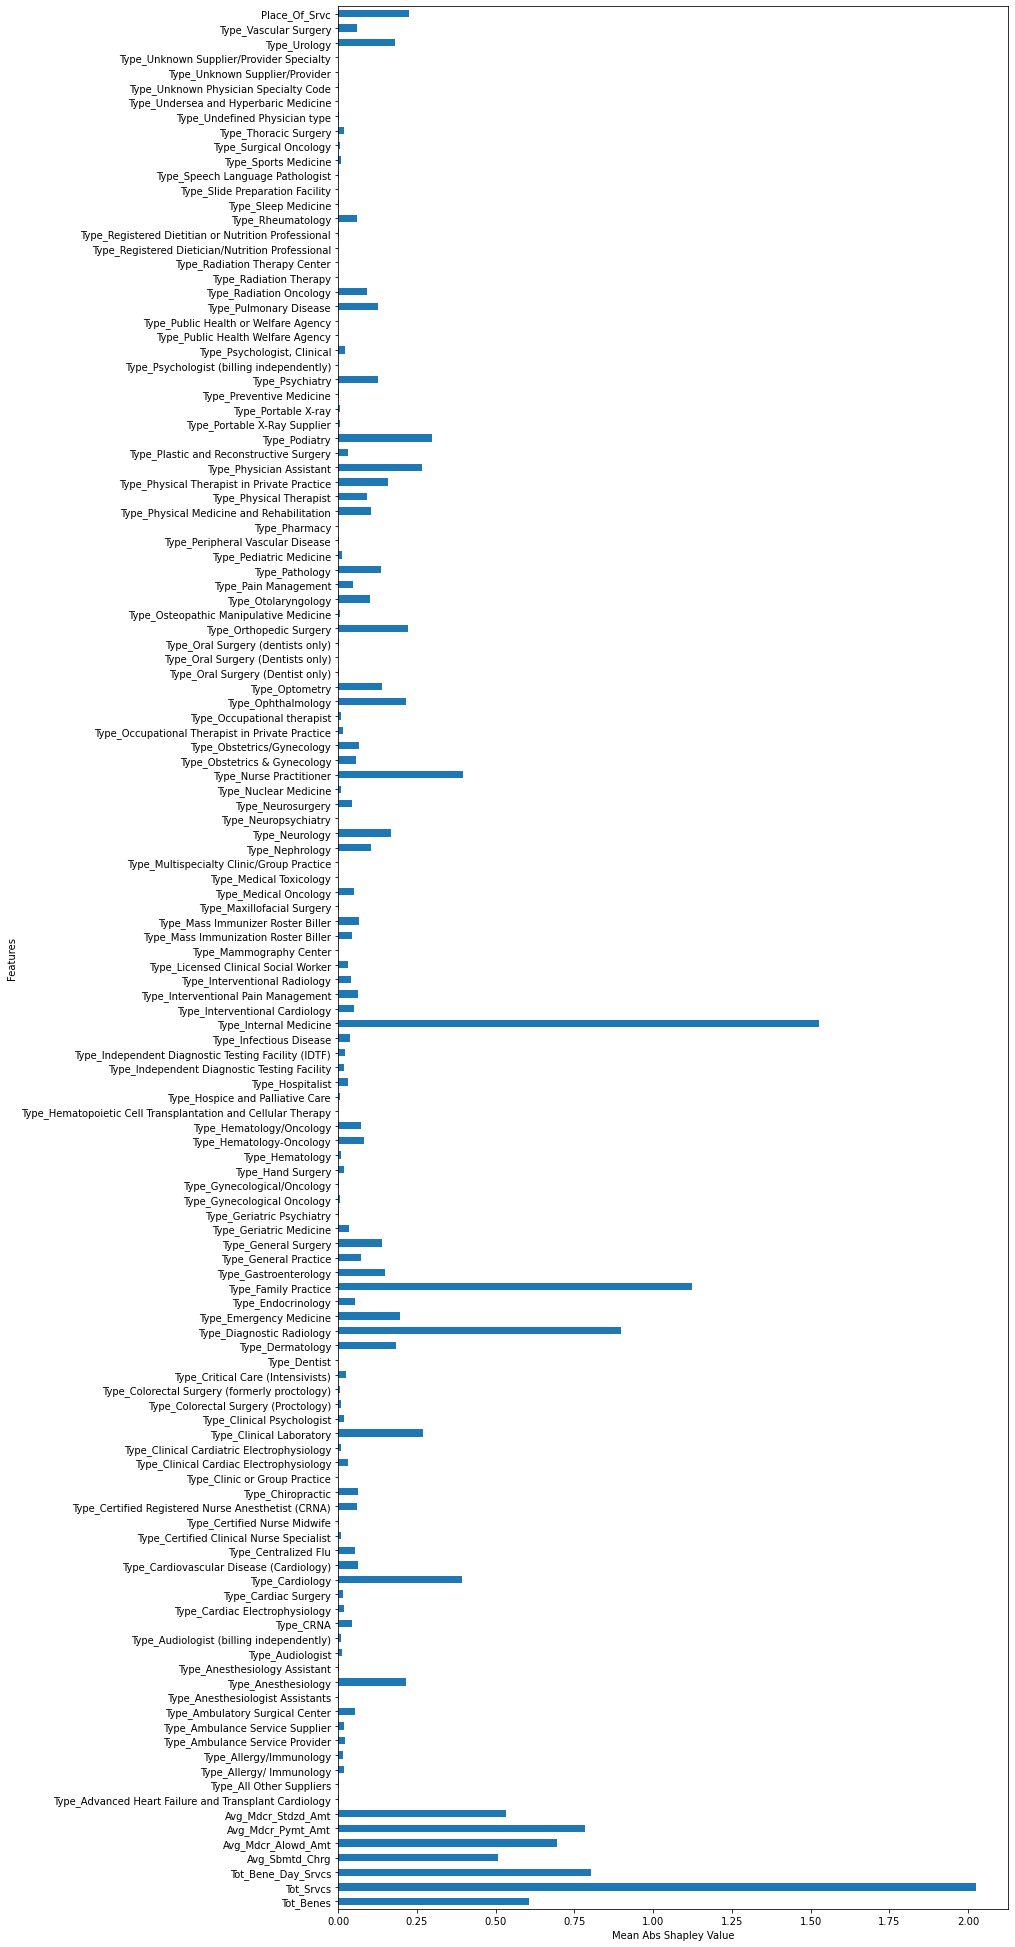

In [80]:
# plot bar chart on the global_fi to see the global feature importance
fig, ax = plt.subplots(figsize=(12,35))
global_fi["MXGB Importance"].plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Mean Abs Shapley Value')
ax.set_ylabel('Features')

In [81]:
# Features with the shapley values above 90 percentiles 
prcntile = np.percentile(global_fi["MXGB Importance"], 90)
top_feat = global_fi[global_fi["MXGB Importance"] >= prcntile].sort_values(by=['MXGB Importance'], axis=0, ascending=False).reset_index()

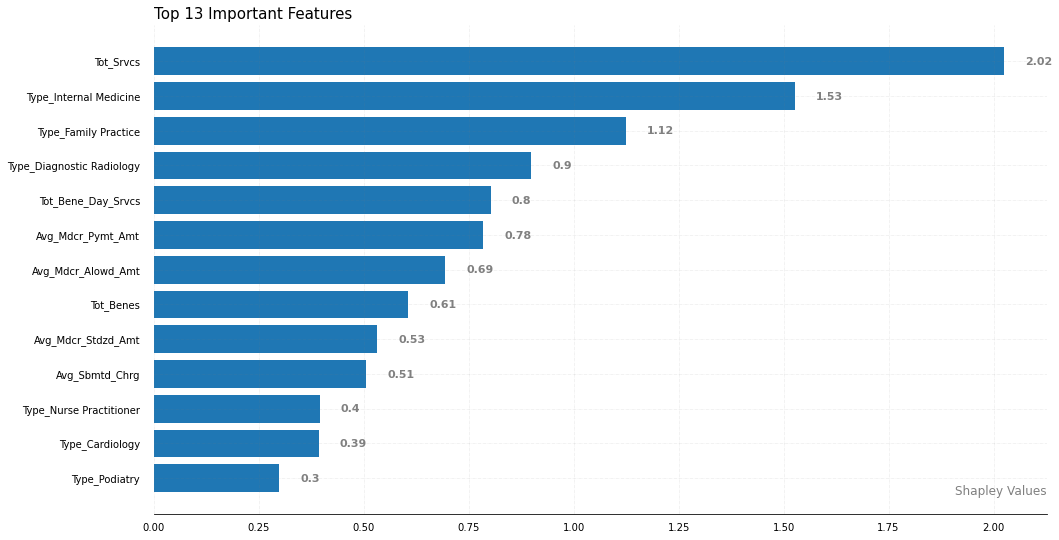

In [82]:
feature = top_feat["index"]
shap = top_feat["MXGB Importance"]
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(feature, shap)
 
# Remove axes splines
for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.05, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 11, fontweight ='bold',
             color ='grey')

# Add Title
ax.set_title('Top 13 Important Features',
             loc ='left', fontsize = 15)
 
# Add Text watermark
fig.text(0.9, 0.15, 'Shapley Values', fontsize = 12,
         color ='grey', ha ='right', va ='bottom')
 
# Show Plot
plt.show()

## Evaluate on Test Set

### Dataframe split by 5 folds

In [83]:
scores_frame = pd.DataFrame(te_df["Fraud"])

# create random folds in reproducible way
np.random.seed(SEED)
scores_frame['fold'] = np.random.choice(5, scores_frame.shape[0])

# create pred column with the outcome predicted on validation set
dtest = xgb.DMatrix(te_df[X_var])
scores_frame["xgb_pred"] = best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit)

# sanity check 
scores_frame

,Fraud,fold,xgb_pred
14317,0,3,0.003505
251078,0,4,0.001797
84400,0,4,0.000652
160114,0,0,0.001049
337935,1,1,0.358680
...,...,...,...
11694,0,0,0.626094
209023,0,3,0.000265
184295,0,4,0.024901
360679,1,2,0.870386


### Utility function for max. accuracy

In [84]:
def max_acc_new(y, phat, res=0.01): 
    
    # init frame to store acc at different cutoffs
    acc_frame = pd.DataFrame(columns=['cut', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = pd.concat([y, phat], axis=1)
    
    # find accuracy at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc_frame = acc_frame.append({'cut': cut,
                                      'acc': acc},
                                     ignore_index=True)

    # find max accurcay across all cutoffs
    max_acc = acc_frame[acc_frame["acc"] == acc_frame['acc'].max()]
   # max_cut = acc_frame[acc_frame['acc'] == max_acc].iloc[0,0]
    
    # house keeping
    del acc_frame, temp_df
    
    return max_acc

### Utility function for max. F1


In [85]:
def max_f1_new(y, phat, res=0.01): 
    
    # init frame to store f1 at different cutoffs
    f1_frame = pd.DataFrame(columns=['cut', 'f1'])
    
    # copy known y and score values into a temporary frame
    temp_df = pd.concat([y, phat], axis=1)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        f1_frame = f1_frame.append({'cut': cut,
                                    'f1': f1},
                                    ignore_index=True)
        
    # find max f1 across all cutoffs
    #max_f1 = f1_frame['f1'].max()
    max_f1 = f1_frame[f1_frame["f1"] == f1_frame['f1'].max()]
    
     # house keeping
    del f1_frame, temp_df
    
    return max_f1

In [86]:
eval_frame = pd.DataFrame() # init frame to hold score ranking
metric_list = ['acc', 'auc', 'f1', 'logloss', 'mse'] # metric to use for evaluation
y_name = 'Fraud'

# create eval frame row-by-row
for fold in sorted(scores_frame['fold'].unique()): # loop through folds 
    for metric_name in metric_list: # loop through metrics
        
        # init row dict to hold each rows values
        row_dict = {'fold': fold,
                    'metric': metric_name}
        
        # cache known y values for fold
        fold_y = scores_frame.loc[scores_frame['fold'] == fold, y_name]
        
        for col_name in scores_frame.columns[2:]:
            
            # cache fold scores
            fold_scores = scores_frame.loc[scores_frame['fold'] == fold, col_name]
            
            # calculate evaluation metric for fold
            # with reasonable precision 
            
            if metric_name == 'acc':
                row_dict[col_name] = np.round(max_acc_new(fold_y, fold_scores).iloc[0,1], ROUND)
                row_dict["cut"] = max_acc_new(fold_y, fold_scores).iloc[0,0]
                
            if metric_name == 'auc':
                row_dict[col_name] = np.round(roc_auc_score(fold_y, fold_scores), ROUND)
                row_dict['cut'] = "-"
                
            if metric_name == 'f1':
                row_dict[col_name] = np.round(max_f1_new(fold_y, fold_scores).iloc[0,1], ROUND) 
                row_dict['cut'] = max_f1_new(fold_y, fold_scores).iloc[0,0]
                
            if metric_name == 'logloss':
                row_dict[col_name] = np.round(log_loss(fold_y, fold_scores), ROUND)
                row_dict['cut'] = "-"
                
            if metric_name == 'mse':
                row_dict[col_name] = np.round(mean_squared_error(fold_y, fold_scores), ROUND)
                row_dict['cut'] = "-"
        
        # append row values to eval_frame
        eval_frame = eval_frame.append(row_dict, ignore_index=True)
        eval_df = eval_frame[["fold", "metric",scores_frame.columns[2],"cut"]]


eval_df

,fold,metric,xgb_pred,cut
0,0.0,acc,0.917,0.91
1,0.0,auc,0.830,-
2,0.0,f1,0.404,0.29
3,0.0,logloss,0.268,-
4,0.0,mse,0.075,-
5,1.0,acc,0.916,0.88
6,1.0,auc,0.839,-
7,1.0,f1,0.419,0.26
8,1.0,logloss,0.265,-
9,1.0,mse,0.074,-


In [87]:
metric_list = ['acc', 'auc', 'f1', 'logloss', 'mse']
dict_mean = {}
 
for metric in metric_list:
    avg = eval_df.loc[eval_df["metric"] == metric, eval_df.columns[2]].mean()
    dict_mean[metric] = np.round(avg, 3)
    
avg_eval_df = pd.DataFrame(dict_mean.items(), columns = ["Metric", "Mean"])
avg_eval_df

,Metric,Mean
0,acc,0.914
1,auc,0.836
2,f1,0.418
3,logloss,0.268
4,mse,0.075


In [88]:
decision_df = scores_frame.copy()
best_cut = eval_df["cut"][(eval_df["metric"] == "f1") 
               & (eval_df.iloc[:,2] == eval_df.loc[eval_df['metric'] == 'f1'].iloc[:,2].max())].iloc[0]

decision_df['Pred'] = np.where(decision_df.iloc[:, 2] > best_cut, 1, 0)
conf_mat = pd.crosstab(decision_df["Fraud"], decision_df['Pred'])

conf_mat

Pred,0,1
Fraud,,
0,62213,5063
1,3657,3071


### ROC curve & AUC


In [89]:
# Create a best mxgb phat dataframe with the prediction on test set
dtest = xgb.DMatrix(te_df[X_var])
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dtest, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
best_mxgb_phat = pd.concat([te_df[X_var].reset_index(drop=True), best_mxgb_phat], axis=1)

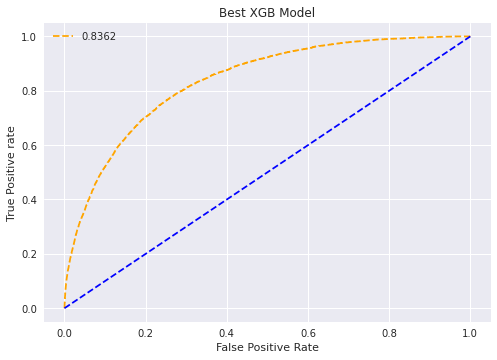

In [93]:
plt.style.use("seaborn")
# valid_roc dataframe
test_roc = te_df.copy(deep=True)
test_roc = test_roc.reset_index(drop = True)

# ROC curve 
fpr, tpr, thresh = roc_curve(test_roc[y_var], best_mxgb_phat.loc[:, "phat"], pos_label=1)

# ROC for tpr = fpr
random_probs = [0 for i in range(len(test_roc[y_var]))]
p_fpr, p_tpr, _=roc_curve(test_roc[y_var], random_probs, pos_label=1)

# auc scores
auc_score = roc_auc_score(test_roc[y_var], best_mxgb_phat.loc[:, "phat"])

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label=np.round(auc_score,4))
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Best XGB Model')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc = "best")
plt.savefig('ROC',dpi=300)
plt.show();

## Export the trained model to S3 bucket

In [89]:
# export the prediction data to S3 default bucket
dtest = xgb.DMatrix(te_df[X_var])
best_mxgb_table = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['Fraud'])
best_mxgb_table.to_csv('best_xgb_No_Group_No_Gender.csv', index=False)


boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/best_xgb_No_Group_No_Gender.csv')).upload_file('best_xgb_No_Group_No_Gender.csv')

In [90]:
# Export test Y to S3 bucket
te_df["Fraud"].to_csv('best_xgb_No_Group_No_Gender_test_Y.csv', index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/best_xgb_No_Group_No_Gender_test_Y.csv')).upload_file('best_xgb_No_Group_No_Gender_test_Y.csv')

In [2]:
! aws s3 ls {bucket}/{prefix}/data --recursive

2021-11-01 21:41:25    6282735 sagemaker-xgboost-fraud-prediction/data/best_ebm_1Rmodel_No_Type_table.csv
2021-11-01 21:41:28     627000 sagemaker-xgboost-fraud-prediction/data/best_ebm_1Rmodel_No_Type_test_Y.csv
2021-11-07 01:00:42    1456945 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Gender.csv
2021-11-07 01:00:50     148014 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Gender_test_Y.csv
2021-11-02 02:30:31         23 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Outlier_CM.csv
2021-11-02 02:30:07         65 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Outlier_avg_eval.csv
2021-11-02 02:30:17        480 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Outlier_eval.csv
2021-11-02 02:23:08    6466610 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Outlier_table.csv
2021-11-01 21:47:05         21 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Type_CM.csv
2021-11-01 21:59:39         64 sagemaker-xgboost-fraud-prediction/data/best_ebm_No_Type_avg_ev

## ---------------------------------------------------

## Import Results

In [215]:
# Import the mxgb model evaluation file from S3
file = os.path.join(prefix, 'data/best_mxgb_performance.csv')
S3URI = 's3://{}/{}'.format(bucket, file)

In [216]:
xgb_eval = pd.read_csv(S3URI)

In [ ]:
pd.set_option('display.max_rows', 50)
xgb_eval